# Twitter Thesis Project: Analyzing tweets 

## Label your tweets (this is a manual step!)


In order to teach the computer how to classify the tweets automatically, we have to feed the program a lot of tweets together with the class they belong to. These example tweets have to be 'labeled' (given a label that indicates which class they belong to) by someone who can tell the correct class simply from reading the tweet (you). 

These are the steps you can take to prepare your tweet dataset for classification:

- decide on the classes you want to use. 
- number these classes from 0 to the number of classes you have - 1. E.g., if you have 4 classes, you need to use the labels 0,1,2,3. 
- add a column to your dataset (or safer: create a copy of your dataset and add a new column there) where you add the correct label for each of your tweets. To start, try to label at least 100 tweets for each class. It will become clear later on if the classifier needs more examples to learn from. 

**Example: tweets with the keyword 'brussel'**

As an example application, we have collected (through streaming) a number of tweets which contain the keyword 'job' or 'hiring'. Our goal is to 'train' a computer program to automatically categorize the collected tweets in two categories: either the tweet is a real job vacancy, or it's something else. 



## Load all the additional libraries and tools we will use

In [1]:
import pandas as pd #this is a datascience library that we will use to load and preprocess the tweets
import matplotlib.pyplot as plt #this is a plotting library that we will use to make graphs
from sklearn.feature_extraction.text import TfidfVectorizer #this is a machine learning tool we will use to find a mathematical representation of the tweets
from sklearn.feature_selection import chi2

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import numpy as np

import scipy.stats as stats
# import researchpy as rp
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
import seaborn as sns

import csv
import os.path
from io import StringIO 


#from scipy.stats import chi2_contingency
#from scipy.stats import chi2

In [2]:
import sklearn
print('The sklearn version is {}.'.format(sklearn.__version__))

The sklearn version is 0.22.1.


## Load the tweets you previously collected and annotated

### Load the annotated tweets

In [26]:
tweet_dataset = pd.read_csv('tweets_mathias.csv', delimiter = ';', skiprows = 0, nrows=3000) #you can change the name of the file you want to load here
tweet_dataset  = tweet_dataset[tweet_dataset.Category == tweet_dataset.Category ] #checking equality will remove NaN
tweet_dataset.Category = tweet_dataset.Category.astype(int) #to make sure the labels are correclty read as integer values
tweet_dataset.head() #this will show the top lines in your dataset


,Date,Place_Name,Place_Bounding_Box,Text,Tweet_Id,IsReplyTo_ID,IsReplyTo_Text,Hashtags,Urls,Media,User_Screen_Name,User_Id,User_Followers_Count,Category,Checked_Status_At,Retweets_Count,Favourites_Count,ID_of_answer,Text_of_answer
1,Mon Apr 26 05:01:43 +0000 2021,NaN,NaN,The price of #Litecoin is currently $239.41\r\...,"1,39E+18",NaN,NaN,", Litecoin, Crypto, LTC",", https://t.co/douu96nAj6",no,coindata_uk,"9,07E+17",611.0,1,NaN,NaN,NaN,NaN,NaN
3,Mon Apr 26 05:01:55 +0000 2021,NaN,NaN,All good for now. I ajusted my stop loss to ma...,"1,39E+18",NaN,NaN,NaN,", https://t.co/4Ee36y2gjN",no,stefan62280,"9,49E+17",388.0,2,NaN,NaN,NaN,NaN,NaN
5,Mon Apr 26 05:03:31 +0000 2021,NaN,NaN,This ALTSTEINN is really Genius!\r\n\r\n🔥💣 @al...,"1,39E+18",NaN,NaN,NaN,", https://t.co/TZg2OoejpL",no,SGulaks,"1,39E+18",8.0,2,NaN,NaN,NaN,NaN,NaN
7,Mon Apr 26 05:04:11 +0000 2021,NaN,NaN,"Guys $band and $iris , both are undervalued at...","1,39E+18",NaN,NaN,NaN,", https://t.co/ZbcVnFunYL",no,bittenachdenken,1951672178,56.0,2,NaN,NaN,NaN,NaN,NaN
9,Mon Apr 26 05:04:12 +0000 2021,NaN,NaN,Thoughts on $LTC #LTC! See ROBINHOODLAB's idea...,"1,39E+18",NaN,NaN,", LTC",", https://t.co/htx7HLQewA, https://t.co/haK6TQ...",no,cryptocharts,3509078064,774.0,1,NaN,NaN,NaN,NaN,NaN


### Make a graph of how many tweets per category you have

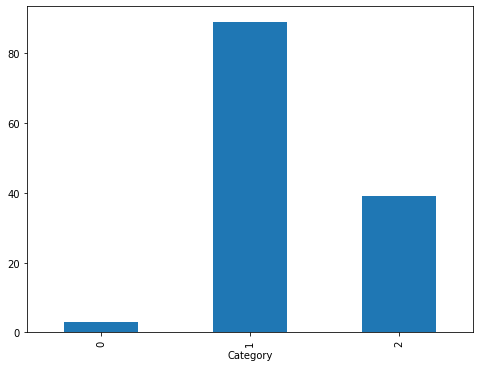

In [28]:
fig = plt.figure(figsize=(8,6))
tweet_dataset.groupby('Category').Text.count().plot.bar(ylim=0)
plt.show()

3


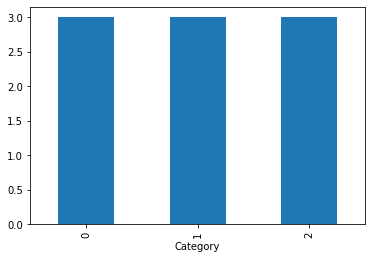

209    👇👇👇👇\r\n\r\n$BTC $ETH $LTC $XLM $LINK $BAT $AL...
47     Fortress Protocol Total Value Locked $15m!\r\n...
247    LTC/USD | $LTCUSD | $LTC $USD\r\n\r\nLTCUSD Ma...
Name: Text, dtype: object


In [29]:
# Separate majority and minority classes
df = tweet_dataset; 
df_lowest_number = df[df.Category==0]
df_higher_number_1 = df[df.Category==1]
df_higher_number_2 = df[df.Category==2]
#df_higher_number_3 = df[df.Category==3]
#df_minority = pd.concat([df[df.Label==0],df[df.Label==1],df[df.Label==2]])

    
n_samples = df_lowest_number.shape[0] #per category
print(n_samples)
oversample = True #sample with replacement, meaning that categories with less samples will contain duplicates such that there are n_samples per category
    
# Downsample majority classes


df_higher_number_0_downsampled = resample(df_lowest_number, 
                                 replace=oversample,    # sample without replacement
                                 n_samples=n_samples,     # to match minority class
                                 random_state=123) # reproducible results


df_higher_number_1_downsampled = resample(df_higher_number_1, 
                                 replace=oversample,    # sample without replacement
                                 n_samples=n_samples,     # to match minority class
                                 random_state=123) # reproducible results

df_higher_number_2_downsampled = resample(df_higher_number_2, 
                                 replace=oversample,    # sample without replacement
                                 n_samples=n_samples,     # to match minority class
                                 random_state=123) # reproducible results


# df_higher_number_3_downsampled = resample(df_higher_number_3, 
#                                  replace=oversample,    # sample without replacement
#                                  n_samples=n_samples,     # to match minority class
#                                  random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_higher_number_0_downsampled , df_higher_number_1_downsampled, df_higher_number_2_downsampled  ])
 
    

tweet_dataset = df_downsampled;
tweet_dataset.groupby('Category').Text.count().plot.bar(ylim=0)
plt.show()


print(tweet_dataset[tweet_dataset.Category == 1].Text)



In [ ]:
##### you can ignore these cells if you don't need classification in two stages


# ## create dataset for binary classification (covid/no-covid) and for second classification (autho/demo/other)


# ##binary classification
# df_no_covid = pd.concat([df_higher_number_0_downsampled , df_higher_number_1_downsampled, df_higher_number_2_downsampled])
# df_covid = df_higher_number_3_downsampled

# #relabel all the no-covid examples with label '0'
# df_no_covid.Category = np.zeros_like(df_no_covid.Category )

# #relabel all the covid examples with label '1'
# df_covid.Category = np.ones_like(df_covid.Category )
# df_binary = pd.concat([df_no_covid, df_covid])

# plt.figure()
# df_binary.groupby('Category').Text.count().plot.bar(ylim=0)
# plt.title('number of labeled examples per category (no covid, covid) ')
# plt.show()




In [ ]:
# #second classification 
# df_final_class =  pd.concat([df_higher_number_0_downsampled , df_higher_number_1_downsampled, df_higher_number_2_downsampled])
# plt.figure()
# df_final_class.groupby('Category').Text.count().plot.bar(ylim=0)
# plt.title('number of labeled examples per category (auth, demo, other) ')
# plt.show()

## Convert the tweet texts to an input format the classifier can read

The classifier, i.e., a computer program, will perform certain mathematical operations on each tweet to determine which class it belongs to. We thus have to feed the classifier with a mathematical representation of the tweet. We will used a method called 'bag of words' to find mathemical representations (in the form of **vectors**) for each tweet text. 

### Convert the tweets to vectors

In [32]:
tweet_dataset = df_final_class

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(tweet_dataset.Text).toarray()
labels = tweet_dataset.Category

ValueError: max_df corresponds to < documents than min_df

### (Intermezzo: Check the important words per class)

In [33]:

#change the name of the classes here

#class_to_labels = {
#    'mobility' : 0, 
#    'politics' : 1, 
#    'sprouts' : 2, 
#    'other' : 3
#}

class_to_labels = {
    'authoritarian' : 0, 
    'democratic' : 1,
    'other':2
    #'covid':3
}




N = 10
for category, label in sorted(class_to_labels.items()):
    
    features_chi2 = chi2(features, labels==label)
    
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print('')
    print('***************************')
    print("# '{}'".format(category))
    print('')
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print('')
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print('')
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

NameError: name 'features' is not defined

## Train a classifier on the tweets represented as vectors 

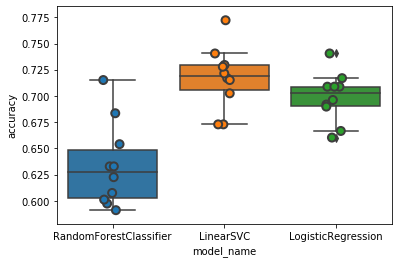

In [10]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

(1425, 446)
number of test samples of category 0:  53
number of test samples of category 1:  58
number of test samples of category 2:  48


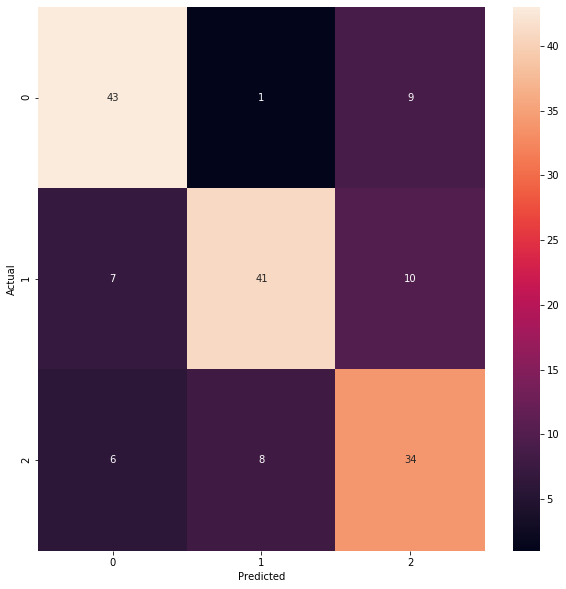

In [11]:
#We select the best model to continue. Before the actual classification, we use it on a part of the labeled dataset 
# to visualize how well it performs. 


model_final = LinearSVC()#LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, tweet_dataset.index, test_size=0.10, random_state=0)
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)

print(X_train.shape)

print('number of test samples of category 0: ', np.where(y_test==0)[0].shape[0])
print('number of test samples of category 1: ',np.where(y_test==1)[0].shape[0])
print('number of test samples of category 2: ', np.where(y_test==2)[0].shape[0])

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

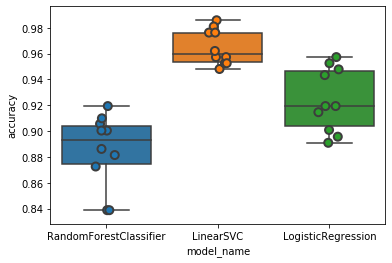

In [12]:
### we now repeat this (i.e., train a new model) for the no-covid/covid classification 


tweet_dataset = df_binary


tfidf_covid = TfidfVectorizer(sublinear_tf=True, min_df=10, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf_covid.fit_transform(tweet_dataset.Text).toarray()
labels = tweet_dataset.Category


models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

number of test samples of category 0:  158
number of test samples of category 1:  54


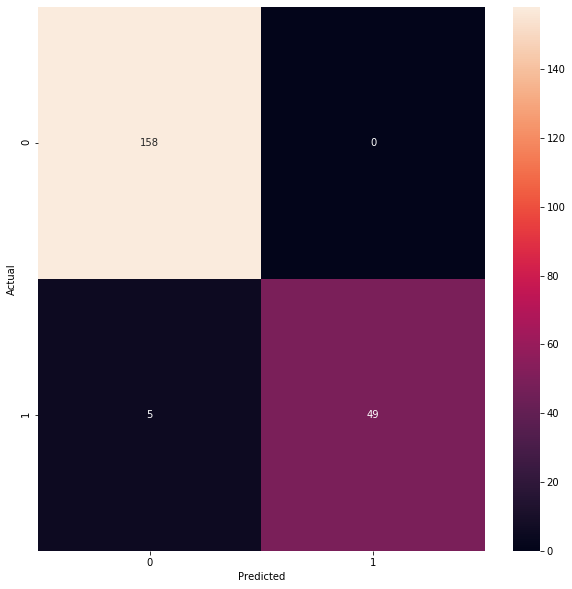

In [13]:

model_covid = LinearSVC()#LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, tweet_dataset.index, test_size=0.10, random_state=0)
model_covid.fit(X_train, y_train)
y_pred = model_covid.predict(X_test)

print('number of test samples of category 0: ', np.where(y_test==0)[0].shape[0])
print('number of test samples of category 1: ',np.where(y_test==1)[0].shape[0])


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
#sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classify complete dataset

In [14]:
import csv
import os.path
from io import StringIO 

delimiter = ';'

#the file of collected tweets that you want to get the counts for:
#filenames = ['pinera.csv']   #change the filename here 

unclassified_filenames = ['pinera.csv']
result_filename = 'classifiedPinera.csv'

col_Text = 3
col_Predictions = -1 #predicted labels will be stored in the last column

total_n_tweets = 0
line_count = 0

with open (result_filename,'w', encoding='utf-8') as outfile:
    wtr = csv.writer(outfile, delimiter=';')
    #wtr.writerow(['Date','Place_Name','Place_Bounding_Box','Text', 'Tweet_Id', 'IsReplyTo_ID','IsReplyTo_Text', 'Hashtags','Urls','Media','User_Screen_Name', 'User_Id', 'User_Followers_Count', 'Checked_Status_At','Retweets_Count','Favourites_Count', 'Labeled_Vacancy', 'Predicted_Vacancy']) #this is the document header
    wtr.writerow(['Date','Place_Name','Place_Bounding_Box','Text', 'Tweet_Id', 'IsReplyTo_ID','IsReplyTo_Text', 'Hashtags','Urls','Media','User_Screen_Name', 'User_Id', 'User_Followers_Count', 'Checked_Status_At','Retweets_Count','Favourites_Count', 'Label', 'Predicted_Label'])  
        
    for filename in unclassified_filenames:
            with open(filename, mode='r', encoding='utf-8') as csv_file:
                
                
                
                csv_reader = csv.reader(csv_file, delimiter=delimiter)
                for tweet in csv_reader:
                    print('*********')
                    #print(tweet)
                    if (tweet and tweet[0] and line_count > 0):
                        
                        #try:
                            #tweetWrap = StringIO(tweet[col_Text])  
                            #df = pd.read_csv(tweetWrap, sep =";") 
                            
            
                            if not tweet[col_Text][0:2]=='RT':

                                df = pd.DataFrame(data=tweet[col_Text], index=["row1"], columns=["Text"])
                                print(tweet[col_Text])
                                #df=tweet[col_Text]
                                tweet_as_vector = tfidf_covid.transform(df.Text).toarray()

                                #first we check if the tweet is about covid
                                predicted_covid = model_covid.predict(tweet_as_vector)[0]


                                if (predicted_covid == 0): #the model predicts this tweet is not about covid
                                    print('not about covid')
                                    #we can now predict its actual class
                                    tweet_as_vector = tfidf.transform(df.Text).toarray()
                                    label_predicted = model_final.predict(tweet_as_vector)[0]
                                    print('further predicted as ', label_predicted)
                                    tweet[col_Predictions] = label_predicted 
                                    total_n_tweets = total_n_tweets + 1
                                    wtr.writerow(tweet)
                                else:
                                    print('about covid')
                            else:
                                print('retweet, removed from classification')
#                         except:
#                             print('could not parse tweet')
                    line_count = line_count + 1
                    
print(total_n_tweets)

*********
*********
Presidente Fernández @alferdez: le deseo una pronta y completa recuperación del COVID-19 y envío un cariñoso saludo… https://t.co/AmrKCWn45I
about covid
*********
El 83% de personas +60 están vacunadas con al menos una dosis y seguiremos trabajando para cumplir la meta de vacun… https://t.co/o0cj8LbL8E
not about covid
further predicted as  2
*********
Proteger la salud de todos nuestros compatriotas ha sido siempre nuestra primera prioridad. Y proteger la salud de… https://t.co/BXcz9LxZpm
not about covid
further predicted as  1
*********
Hace 10 años @ceciliamorel inició un proyecto para promover hábitos más saludables para mejorar la calidad de vida… https://t.co/mNiZbhqSzk
not about covid
further predicted as  2
*********
Con el aporte y mérito de todos hemos vacunado a 5MM de personas, lo q corresponde a nuestra población de riesgo y… https://t.co/qEJXbcgh1k
about covid
*********
En las últimas 24 hrs se han vacunado más de 400.000 personas, alcanzando un total d

not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Los incendios forestales se agravan en todo el mundo. El pronóstico es que Chile tendrá una temporada difícil y exi… https://t.co/hw5z2mckwl
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Pronto enviaremos Informe a @ONU_es para extender hasta 550 mil km2 nuestra plataforma continental de Isla Salas y… https://t.co/lTtnlgpB4L
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Estamos comprometidos con un Plebiscito transparente, informado, participativo y seguro. Con resguardos sanitarios… https://t.co/uVzvXsW221
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
El programa #AdultoMejor ha impulsado mejoras en pensiones, salud, rebajas en remedios, transport

further predicted as  1
*********
retweet, removed from classification
*********
No permitamos que la distancia física se transforme en distancia social. Especialmente con los adultos mayores.

Co… https://t.co/J5nVVRTGlR
not about covid
further predicted as  1
*********
La concurrencia de voluntades y corazones de muchos permitió este Acuerdo por la Protección Social y Recuperación d… https://t.co/hZeGmkh5KI
not about covid
further predicted as  2
*********
El Dr Mañalich es un gran servidor público. Puso la salud de los chilenos por encima de todos sus legítimos interes… https://t.co/hLbxzDm4Vr
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Hoy superamos el millón de cajas de #AlimentosParaChile. 

Ya hemos golpeado la puerta de 1MM de hogares para lleva… https://t.co/WxYXMo7HfY
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
La droga destruye vidas, sueños y familias; arrebata talentos

not about covid
further predicted as  1
*********
Buenas noticias.Hoy gracias a una donación de la CPC y un grupo de empresas,recibimos 117 nuevos ventiladores mecán… https://t.co/ls79xel7cn
not about covid
further predicted as  1
*********
En el #DíaDelTrabajo quiero reconocer, valorar y agradecer el enorme aporte que hacen los trabajadores y trabajador… https://t.co/YirgF0UVF3
not about covid
further predicted as  1
*********
Buenas noticias para todos los chilenos desde el aeropuerto  https://t.co/XmxSSE3qsl
not about covid
further predicted as  1
*********
#COVID19 exige urgentes esfuerzos de investigación del virus y sus efectos en sociedad. Chile cuenta con comunidad… https://t.co/SLir3xNI4H
about covid
*********
[VIVO] Comparto anuncio que apoyará la investigación y desarrollo de #CienciaParaChile https://t.co/ZiavRPy8bc
not about covid
further predicted as  2
*********
Como parte de la Red de Protección Social q hemos construido hoy sumamos el Seguro de Ingresos para Trabajador

further predicted as  2
*********
Hoy, regresando a mi casa, pasé por Plaza Baquedano, me bajé un par de minutos a saludar a un grupo de Carabineros… https://t.co/mcZZ6SCRT2
not about covid
further predicted as  2
*********
#CuidémonosEntreTodos 🇨🇱 https://t.co/jiCxGE8huf
not about covid
further predicted as  2
*********
Frente a Pandemia de Coronavirus y la angustia de miles de compatriotas q temen perder su trabajo o no poder llegar… https://t.co/10jP4rR1Uu
about covid
*********
[EN VIVO] Promulgación Ley de Ingreso Mínimo Garantizado https://t.co/RJIuhTmxXP
not about covid
further predicted as  2
*********
Cuidar la salud y la economía de nuestros compatriotas es nuestra prioridad. Hoy Ministro de Salud @jmanalich llegó… https://t.co/tzzFjsGmLb
not about covid
further predicted as  1
*********
Promulgamos Ley de Protección de Empleos, Ingresos y Pymes frente a amenaza de #Covid19. Agradezco la colaboración… https://t.co/VBBbNdW1BR
not about covid
further predicted as  1
*********
[V

not about covid
further predicted as  0
*********
#COVIDー19 alcanzó Fase 3 en Chile lo que significa que hay casos de Coronavirus sin trazabilidad lo q incrementa ri… https://t.co/jFqMhQPupK
about covid
*********
Hola Andrea, por supuesto q puede volver a su país. 2/3 de los pasajeros q llegan al aeropuerto son chilenos tambié… https://t.co/VDJWN7rZjZ
not about covid
further predicted as  1
*********
Hola Andrea; en estas materias hay que ser muy responsable y conscientes de lo que implica cada decisión. Por eso,… https://t.co/MZFf18k5VB
not about covid
further predicted as  2
*********
[EN VIVO] Compartimos información relevante y anunciamos medidas preventivas sobre Coronavirus https://t.co/sAlk9dz1ak
about covid
*********
Los chilenos queremos un país más justo,sin abusos,sin privilegios y sin corrupción. La Constitución dice q todos n… https://t.co/EDdwknn98l
not about covid
further predicted as  1
*********
Coronavirus es una grave amenaza para Chile y el mundo.Nos hemos preparado

*********
Junto a los Ministros, Subsecretarios e Intendentes estamos haciendo una evaluación del difícil año q terminó y una… https://t.co/gsz45QpeYz
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Acompañamos y compartimos hoy el dolor de nuestros compatriotas afectados por inundaciones y aluviones en Atacama.… https://t.co/EAiat7xLdq
not about covid
further predicted as  1
*********
Vamos camino a Alto del Carmen para revisar y disponer en terreno, medidas de apoyo a los damnificados por las inun… https://t.co/V4pz6Ne7Kp
not about covid
further predicted as  1
*********
A pesar de incidentes aislados, casi todos los estudiantes dieron hoy su PSU de matemáticas y lenguaje y podrán pos… https://t.co/CreobJ7Oqg
not about covid
further predicted as  1
*********
1,6mm de pensionados Pilar Solid ya están recibiendo sus pensiones mejoradas.Ahora #SubamosLasPensiones a 850mil ju… https://t.co/Pyaqt9ELZI
not about covid
further predicted as  1

not about covid
further predicted as  1
*********
El proyecto tiene dos ventajas: Proteger mejor nuestra infraestructura básica, esencial para el desarrollo de Chile… https://t.co/QbyjzGWH6B
not about covid
further predicted as  1
*********
Proyecto de Ley para que FFAA colaboren en protección de infraestructura crítica permite, sin restringir libertades… https://t.co/a3oh4KoYwd
not about covid
further predicted as  0
*********
Tenemos q actuar con mayor urgencia.Muchos otros proyectos esperan en el congreso para dar + seguridad a los chilen… https://t.co/LHcyE5tcAV
not about covid
further predicted as  1
*********
Lamentamos profundamente cada una de las muertes ocurridas y los miles de civiles q han sido heridos. También lamen… https://t.co/DSeG73J8wu
not about covid
further predicted as  0
*********
El debilitamiento de nuestras Fuerzas de Orden y Seguridad solo favorece a la violencia y delincuencia. El sistema… https://t.co/OgUPILOJca
not about covid
further predicted as  0
******

not about covid
further predicted as  2
*********
Queridos compatriotas, en los próximos minutos compartiré algunas reflexiones y un conjunto de propuestas para una… https://t.co/UXSF4Sp1Bd
not about covid
further predicted as  1
*********
[EN VIVO] https://t.co/uex0m2qmmM
not about covid
further predicted as  2
*********
[EN VIVO] https://t.co/YhWWzGgR0g
not about covid
further predicted as  2
*********
Todos tienen derecho a manifestarse pacíficamente y solidarizo con razones que tienen para hacerlo. Pero nadie pued… https://t.co/KKkkrSEypT
not about covid
further predicted as  1
*********
He escuchado con humildad la voz de la gente y no tendré miedo a seguir haciéndolo, pq así se construyen las democr… https://t.co/g0Fo1W0i07
not about covid
further predicted as  1
*********
[EN VIVO] https://t.co/sgjvGOMJKu
not about covid
further predicted as  2
*********
[EN VIVO] https://t.co/XAXPzmUgqn
not about covid
further predicted as  2
*********
Agradezco Congreso x grandes avances esta 

not about covid
further predicted as  1
*********
Hoy damos la bienvenida a la “Bendita Primavera” en q los días son +largos y luminosos,las flores +intensas y radia… https://t.co/kno9wUO6GP
not about covid
further predicted as  2
*********
Hoy, 18 de Septiembre, el edificio Burj Khalifa en Dubai, la torre más alta del mundo, se ilumina con nuestra bande… https://t.co/ZLHDA3I8wq
not about covid
further predicted as  2
*********
Que tengan unas Felices Fiestas Patrias. Pásenlo bien, bailen cueca, coman empanadas, eleven volantines y disfruten… https://t.co/ikN9chHrCJ
not about covid
further predicted as  1
*********
Dada enorme gravedad de la sequía, decretamos zona catástrofe en comunas de Valparaíso. La zona ya estaba en emerge… https://t.co/KsEu2tFr1S
not about covid
further predicted as  2
*********
Buenas noticias!

🚧#Un18Seguro 
❌Fin Ley Reservada del Cobre 
🗳Ley Transformación Digital 
🛫Nueva área de embarque… https://t.co/ViWooIz4Ev
not about covid
further predicted as  2
******

further predicted as  1
*********
Hoy visitamos obras Hospital Salvador e Inst. Nacional Geriátrico de Providencia,q junto al anhelado Hospital Zona… https://t.co/dpRWZnnJj8
not about covid
further predicted as  2
*********
¿Sabían q tenemos 1,9 camas públicas x cada mil habitantes en los 196 hospitales de nuestro país? Cifra muy x debaj… https://t.co/jmXEFlM2pF
not about covid
further predicted as  2
*********
Contraloría tomó razón de nuestro Decreto q autoriza colaboración FFAA con Policías para resguardar fronteras del n… https://t.co/QXuAEfEzGu
not about covid
further predicted as  2
*********
[EN VIVO] Respondemos sus dudas sobre el Proyecto de #PortabilidadFinanciera https://t.co/jVWcHIkDEq
not about covid
further predicted as  2
*********
#PortabilidadFinanciera permitirá q costos de refinanciar créditos bajen 57% y q solo se necesite un certificado de… https://t.co/tpOcUoGbv7
not about covid
further predicted as  1
*********
Han tratado de refinanciar su crédito o cambiar de b

not about covid
further predicted as  1
*********
[EN VIVO] Anuncio #NuevasEnfermedadesAUGE https://t.co/BH1WRTyKIG
not about covid
further predicted as  2
*********
Muy feliz #DíadelBombero a todos los @BomberosdeChile en su aniversario 168. Cuando hay peligro la mayoría se aleja… https://t.co/mrqCXbmGnr
not about covid
further predicted as  1
*********
Felicitaciones a Argentina y al Pdte @mauriciomacri por, después de 20 años de negociaciones, haber terminado exito… https://t.co/K4yJfFGcsp
not about covid
further predicted as  1
*********
En la Cumbre del G-20 en Japón, hicimos un compromiso con Inglaterra, Francia, Alemania, Holanda y España, liderado… https://t.co/eaN9GPr2IZ
not about covid
further predicted as  2
*********
Desde la Cumbre del G-20 en Japón, felicitaciones a la selección chilena por un emocionante partido, una impecable… https://t.co/d2T8Tud7Ee
not about covid
further predicted as  2
*********
Estamos en Cumbre G-20 en Japón, gran oportunidad para q China y EEUU a

not about covid
further predicted as  2
*********
Presentamos tb potente plan inversiónes q incluye 17mil km de rutas, 3ras pistas en rutas 5, 68 y 78, nuevos o mejo… https://t.co/RZ9yNKEawt
not about covid
further predicted as  1
*********
Las licitaciones de actuales carreteras se hicieron hace 20 años e incorporaron reajuste anual de 3,5%, q no se jus… https://t.co/bhIgYbffjr
not about covid
further predicted as  0
*********
En #DíaDelPatrimonio Palacio de La Moneda se une a la Casa Blanca como Casa de Gobierno disponible en @GoogleChile… https://t.co/rbS7dULBMs
not about covid
further predicted as  2
*********
Contraloría dictaminó en forma categórica q viaje mis hijos a China cumplió todas las normas de probidad y no signi… https://t.co/wbgJsS08WF
not about covid
further predicted as  1
*********
Este fin de semana celebramos el #DíaDelPatrimonio en todo Chile.Será una gran fiesta cultural con +de 1907 lugares… https://t.co/zg1h5BFii0
not about covid
further predicted as  2
******

further predicted as  2
*********
Agradezco al Senado aprobación de nuestro proyecto de ley de Imprescriptibilidad para Delitos de Abusos Sexuales. N… https://t.co/J6sGIuV7xb
not about covid
further predicted as  1
*********
Necesitamos el compromiso de todos para q la lucha contra las drogas sea efectiva. Tienes dudas sobre el Plan… https://t.co/CpcyKcedUV
not about covid
further predicted as  1
*********
Pronto seguirá fortalecimiento FONASA, a través de un conjunto de iniciativas legales y administrativas, para mejor… https://t.co/3XY01HsLIX
not about covid
further predicted as  1
*********
Este mes nuestro Gobierno presentará al Congreso P.Ley q moderniza Sist. de Isapres, creando un Plan Universal de S… https://t.co/ZWaKSnMgZ1
not about covid
further predicted as  1
*********
Forjemos una poderosa alianza x la salud, libertad y futuro de nuestros niños y jóvenes. Comprometámonos a terminar… https://t.co/OFKm5o1dV2
not about covid
further predicted as  1
*********
Porque la droga m

not about covid
further predicted as  1
*********
Duele en el alma el femicidio ocurrido hoy en Recoleta, el día en que conmemoramos el #8M2019. Ya son 11 cobardes a… https://t.co/89S0QSzhP9
not about covid
further predicted as  2
*********
Hoy firmamos proy #LeyCiberAcoso q castigará todo delito de acoso cibernético. Estamos 100% comprometidos con igual… https://t.co/f6iTStZUuN
not about covid
further predicted as  1
*********
[EN VIVO] #DíaDeLaMujer #8M2019 https://t.co/KnvGxamC51
not about covid
further predicted as  2
*********
247 mil niños iniciaron su #AñoParvulario2019, pero aún hay 230 mil q no tienen esa oportunidad. Hoy redoblamos com… https://t.co/J7V1VUPvHI
not about covid
further predicted as  1
*********
Hoy el Senado aprobó el nuevo Ministerio de Familia y Desarrollo Social, que nos permitirá incorporar y desarrollar… https://t.co/pEROV2LhRV
not about covid
further predicted as  1
*********
Por todas estas razones, y porque Chile y los chilenos necesitamos modernizacion

further predicted as  0
*********
La tecnología digital es poderosa herramienta para unir a los chilenos y mejorar su calidad de vida. X eso durante… https://t.co/rB6OBsHvLB
not about covid
further predicted as  2
*********
Envío mi solidaridad a las familias afctadas por el desborde de ríos en la región de Arica y Parinacota. He pedido… https://t.co/gCkSCpU2N5
not about covid
further predicted as  1
*********
Los precios de las bencinas llevan 15 semanas consecutivas cayendo. Y según nuestras estimaciones, seguirán bajando… https://t.co/q5HbftVT1N
not about covid
further predicted as  2
*********
Tras 16 años, Juez Madrid determinó que muerte del Pdte Frei Montalva fue homicidio. Condenamos con indignación est… https://t.co/u5rTOXG4vd
not about covid
further predicted as  2
*********
Exigimos inmediata liberación de periodistas de @TVN detenidos en #Venezuela. Nuestra Cancillería está realizando t… https://t.co/kotpqPszPg
not about covid
further predicted as  0
*********
El Gobierno d

not about covid
further predicted as  1
*********
[EN VIVO] Nuevo Ministerio de Ciencia, Tecnología, Conocimiento e Innovación #NuevoMinisterioCiencia https://t.co/j4Y8BqIqgJ
not about covid
further predicted as  2
*********
Este desafío nos compromete y nos hace recordar las palabras del ex Presidente @BarackObama, cuando afirmó que nues… https://t.co/Xkx7ej4LEd
not about covid
further predicted as  1
*********
En #COP25 tendremos la responsabilidad de promover con decisión, políticas y avances para controlar el cambio climá… https://t.co/4iIjlWxHFo
not about covid
further predicted as  2
*********
Hoy Chile 🇨🇱 recibió un gran reconocimiento: nuestro país es sede del principal foro de cambio climático en el mund… https://t.co/ssrxw5ckDi
not about covid
further predicted as  2
*********
[EN VIVO] Palabras sobre la política migratoria de Chile. https://t.co/ZGq3dCToSm
not about covid
further predicted as  2
*********
Chile está nuevamente en marcha y recuperando la senda del desarrollo:

further predicted as  2
*********
Todo nuestro apoyo para nuevo intendente @jatton. Tendrá la exigente pero maravillosa misión de avanzar con Plan Ar… https://t.co/SWYLjfdU38
not about covid
further predicted as  2
*********
Una buena noticia para compartir:Mañana,y por quinta semana consecutiva,bajarán los precios de los combustibles.Est… https://t.co/6IthfFawnY
not about covid
further predicted as  1
*********
Firmamos TLC con Brasil q eliminará cobros de roaming, permitirá a pymes y proveedores participar en licitaciones y… https://t.co/l7lv2nLXF3
not about covid
further predicted as  2
*********
Este martes Comisión de Constitución de Cámara de Diputados aprobó x unanimidad proyecto de nuestro Gobierno q mode… https://t.co/sD3gYJ8aaH
not about covid
further predicted as  1
*********
Agradezco a gran mayoría diputados q pusieron hoy a #LosNiñosPrimero votando a favor + recursos a hogares colaborad… https://t.co/37nupjyWaa
not about covid
further predicted as  1
*********
En el Día d

No vamos a permitir ni dejar en la impunidad a delincuentes disfrazados de estudiantes que destruyen sus propios co… https://t.co/H5ln2WIt2R
not about covid
further predicted as  0
*********
Gran reunión con Pdte @EmmanuelMacron para cerrar visita a París. Avanzamos en libre comercio, defensa, medioambien… https://t.co/rGfD8yF6fX
not about covid
further predicted as  1
*********
[EN VIVO] Desde París, tras reunirnos con @EmmanuelMacron https://t.co/HA4b59rdMO
not about covid
further predicted as  2
*********
Hace 30 años vivimos un día luminoso e inspirador para nuestra democracia y abrimos el camino hacia una transición… https://t.co/KyF9Gh9JwW
not about covid
further predicted as  1
*********
Esto significará mayor calidad, seguridad y regularidad en el transporte público y también más tiempo libre para la… https://t.co/FrD3bymbRl
not about covid
further predicted as  0
*********
El Plan Tercer Milenio llegará a todas las Regiones de Chile. En Santiago, el Metro será eje estructurant

not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Lamento profundamente q oposición no haya aprobado reajuste de 9% salario mínimo y q busquen rechazar sin discusión… https://t.co/7q9Y9FtFHC
not about covid
further predicted as  2
*********
Tomaremos el toro por las astas para cambiar la historia de Puchuncaví y Quintero. Pondremos en práctica Plan de De… https://t.co/5e7dn55sPH
not about covid
further predicted as  2
*********
El #PlanDeInversionesEnSalud es parte de la Cirugía Mayor a la Salud. Al 2026 Chile tendrá 57 nuevos hospitales púb… https://t.co/cRmVGCaN4u
not about covid
further predicted as  1
*********
Encuesta Casen 2017 muestra consecuencias débil crecimiento durante gobierno NM: Disminuye ritmo caída pobreza… https://t.co/bMDSuTZtIW
not about covid
further predicted as  1
*********
Frente contaminación con gases tóxicos en Quintero y Puchuncavi actitud gobierno es clara :1. proteger salud de las… https://t.co/adisI9ZyrC
not

further predicted as  1
*********
El  proyecto de #LeyPagoA30Días a las Pymes significa darles oxígeno, fortaleciendo su capital de trabajo para que… https://t.co/VCVIMn2S32
not about covid
further predicted as  1
*********
Hoy firmamos Proyecto de Ley que crea el #MinisterioDeFamilia y Des. Social. La familia -todas las familias, pq hay… https://t.co/9IxyTSYumI
not about covid
further predicted as  1
*********
Respecto a beneficios de migrantes, creemos que el acceso a educación y salud debe ser para todos y sin requisitos.… https://t.co/UEt6LyIgyV
not about covid
further predicted as  1
*********
Algunos parlamentarios aprobaron indicación restringiendo la facultad del Estado de expulsar extranjeros. Creemos q… https://t.co/Z5dcLbzOv1
not about covid
further predicted as  1
*********
Estamos comprometidos con #OrdenarLaCasa. Nuestra nueva política de migración permitió que 265.257 extranjeros inic… https://t.co/042ly8PLAR
not about covid
further predicted as  0
*********
Una Cumbre m

not about covid
further predicted as  2
*********
Hoy se condenó a presidio perpetuo por delito terrorista a dos de los autores del cruel y cobarde asesinato del mat… https://t.co/dNtHs8BZmp
not about covid
further predicted as  0
*********
Hoy firmamos proyecto de #LeyAntiPortonazo, el que junto al fortalecimiento de la ley Penal Juvenil y de Control de… https://t.co/kS367pUWRu
not about covid
further predicted as  2
*********
En estos días hará mucho frío. Es importante que nadie duerma en las calles. Revisa los albergues que implementamos… https://t.co/0RbEZuh9nT
not about covid
further predicted as  2
*********
Desde hoy tenemos el área marina protegida más grande de América Latina y es en Rapa Nui. Una gran noticia para nue… https://t.co/zWGZ4ykJSj
not about covid
further predicted as  2
*********
Ayer,junto al Pdte  @AndresPastrana,conversamos con @MariaCorinaYA,valiente y  perseverante defensora de la liberta… https://t.co/ZyFfrJeOM9
not about covid
further predicted as  2
*****

further predicted as  1
*********
En 10 días, más de 75 mil migrantes han podido registrarse para regularizar su situación. Y hoy tenemos una migraci… https://t.co/Kx9x88FxTV
not about covid
further predicted as  2
*********
favorece la impunidad, dejando crímenes sin castigo. Por eso impulsaremos una reforma al Código Penal, que establec… https://t.co/HbtCFIxCtd
not about covid
further predicted as  2
*********
No hay atentado más miserable y cobarde contra la inocencia de los niños que el abuso sexual. No solo hiere su cuer… https://t.co/bcwDnJnVV1
not about covid
further predicted as  1
*********
Hoy recibimos al gran escritor y premio Nobel Mario Vargas Llosa, con quien tuvimos un diálogo profundo en torno a… https://t.co/qzCCcjnpKU
not about covid
further predicted as  1
*********
En el Bicentenario de la @armada_chile inauguramos el #MesDelMar, destacando su ejemplar servicio al proteger y def… https://t.co/RiX5I0ijW8
not about covid
further predicted as  2
*********
No hay mejor

further predicted as  2
*********
Valoro y agradezco su voluntad de participar y aportar a una vida más plena y feliz para nuestros niños. Les he ped… https://t.co/U9NQojLudk
not about covid
further predicted as  2
*********
Hoy nos reunimos junto a un Grupo de Trabajo para promover un Acuerdo Nacional por la Infancia. Su objetivo es mejo… https://t.co/KNJBtnwgiH
not about covid
further predicted as  1
*********
Pascua de Resurrección significa renacer, un nuevo comienzo. Por eso la celebramos en la Moneda con niños de Chile.… https://t.co/ORZ0Gdpoe4
not about covid
further predicted as  2
*********
Vamos a potenciar nuestras  regiones, comunas y cada localidad. Deben alcanzar el protagonismo que se merecen y apr… https://t.co/f2UW3H8ZlR
not about covid
further predicted as  0
*********
En un sábado santo 31 de marzo como hoy , el año 1866 , el almirante español Casto Méndez Nuñez bombardeó e incendi… https://t.co/2kV2kUNgZK
not about covid
further predicted as  2
*********
En el Día d

not about covid
further predicted as  1
*********
Los chilenos, con la misma unidad, fe y esperanza, tenemos que emprender la nueva transición: la que nos conducirá… https://t.co/1jPLPsFsox
not about covid
further predicted as  1
*********
Convoco a todos los chilenos de buena voluntad a tomar su lugar para aportar y recibir una justa participación de l… https://t.co/hkTejSgj7m
not about covid
further predicted as  1
*********
Hoy llegamos a esta casa de todos los chilenos, con el firme y urgente compromiso de hacer justicia y mejorar la di… https://t.co/dosDUsqfJp
not about covid
further predicted as  1
*********
[EN VIVO] Gracias chilenos por acompañarnos en este gran día  #ChileLoHacemosTodos https://t.co/4RgyyySOtU
not about covid
further predicted as  2
*********
Los necesito a todos ustedes, porque en esta misión no sobra nadie y son todos bienvenidos. Hagamos de Chile una Pa… https://t.co/u0zc33WsnD
not about covid
further predicted as  2
*********
Hoy, 8 años después de haber a

El progreso sólo es posible cuando no dejamos a ningún chileno atrás. Le he pedido a los Intendentes que lideren ca… https://t.co/3dBOdxn165
not about covid
further predicted as  1
*********
Los niños son el futuro de Chile, y por eso en nuestro próximo Gobierno estarán primero en la fila. La Subsecretarí… https://t.co/ZYwhXg9WA0
not about covid
further predicted as  1
*********
Bienvenida a la Ingeniera Comercial Pamela Gidi (@pamgidi), nuestra nueva Subsecretaria de Telecomunicaciones. Conf… https://t.co/O8IxQuyaHK
not about covid
further predicted as  0
*********
El economista Rodrigo Cerda (@rcerdan) asumirá como Director de Presupuestos en el Ministerio Hacienda. Durante nue… https://t.co/OpWSX7hL3V
not about covid
further predicted as  2
*********
Bienvenido Juan Carlos Silva. El abogado asumirá este 11 de marzo como Subdirector del Consejo Nacional de la Cultu… https://t.co/HJDBF1nJbR
not about covid
further predicted as  1
*********
Carolina Cuevas formó parte de los equipos pr

not about covid
further predicted as  2
*********
@RNchile @udipopular @evopoli Y también a los Independientes y adherentes de #ChileVamos. Ahora viene lo más hermos… https://t.co/dNH0SUf73Z
not about covid
further predicted as  2
*********
Muy feliz tercer cumpleaños #ChileVamos. Salió de verso sin mayor esfuerzo. Pocas Coaliciones Políticas han logrado… https://t.co/JIAD79zZTf
not about covid
further predicted as  2
*********
Nos estamos preparando para trabajar por Chile y tu familia. Junto a nuestro Gabinete ya iniciamos extensas jornada… https://t.co/YhrjjWGNm8
not about covid
further predicted as  1
*********
Vamos a trabajar hombro con hombro con todos los alcaldes de Chile. Ayer nos reunimos con @AmuchChile y hoy con… https://t.co/OXIRW22Aaa
not about covid
further predicted as  1
*********
Rindo sentido homenaje a Nicanor Parra, verdadero gigante  nos ha dejado y cuyo talento, irreverencia e imaginación… https://t.co/3cgMWDz3KT
not about covid
further predicted as  1
*********

not about covid
further predicted as  1
*********
Agradezco a los chilenos el apoyo, cariño y confianza para liderar a nuestro país hacia una patria buena, justa y f… https://t.co/PxXRpxDRwe
not about covid
further predicted as  1
*********
Nuestro compromiso con la libertad y democracia es absoluto y trasciende fronteras. Hoy nos reunimos con la ex Fisc… https://t.co/qvwhFfht6N
not about covid
further predicted as  1
*********
Esta tarde con el Ministro de Energía @AndresReboll, analizamos las enormes oportunidades y desafíos en materia de… https://t.co/HC2A5hvMls
not about covid
further predicted as  2
*********
Ayer, en  una reunión con el Canciller @HeraldoMunoz, analizamos los múltiples temas de interés de Chile en materia… https://t.co/Y9Nq3vK9BP
not about covid
further predicted as  1
*********
Gracias 2017, gracias @ceciliamorel, familia y amigos. A pocos minutos de iniciar un nuevo año, siento profunda gra… https://t.co/S7VC5BrbId
not about covid
further predicted as  1
******

further predicted as  1
*********
En el #DiaDeLosDerechosHumanos  es bueno recordar que ninguna circunstancia, de ninguna naturaleza, justifica la vi… https://t.co/yNbhvdGSf5
not about covid
further predicted as  2
*********
A los miles de voluntarios y apoderados de todo Chile, les agradezco la energía y el compromiso. El próx domingo ga… https://t.co/RquAKIM985
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Haremos q todas las familias chilenas tengan un parque o plaza como patio trasero de su casa. Donde puedan recrears… https://t.co/PI0Vi64TPb
not about covid
further predicted as  1
*********
Los chilenos necesitan y merecen una mejor educación.Nosotros tenemos un buen plan para lograrlo: Mejorando la cali… https://t.co/UCRsp3ZnT0
not about covid
further predicted as  1
*********
Te esperamos ahora en el #DebateArchi. Porque queremos un país más desarrollado, justo y solidario. Un Chile con ti… https://t.co/Bfgk20aLrr
not about covi

further predicted as  0
*********
Gracias @ceciliamorel por ser la madre de nuestros cuatro hijos y el pilar emocional de nuestra familia. Eres una f… https://t.co/COAR0kYcoj
not about covid
further predicted as  1
*********
Partiendo el día con energía y fe, junto a la mejor compañera @ceciliamorel en este gran desafío de los… https://t.co/P9Cqo2k46e
not about covid
further predicted as  2
*********
Gracias a cada uno de los chilenos que ayer votó por los #TiemposMejores, por un Chile más libre, justo, próspero y… https://t.co/BcvXgxKIsZ
not about covid
further predicted as  1
*********
Este año se cumplen 65 años desde que las mujeres chilenas votaron por primera vez en una elección presidencial, y… https://t.co/di9vC69uz4
not about covid
further predicted as  2
*********
En familia, acompañado de mi mujer @ceciliamorel, mis hijos y nietos. Vota porque también queremos escuchar tu voz… https://t.co/Ttwu8UCO0C
not about covid
further predicted as  1
*********
El futuro de Chile está e

not about covid
further predicted as  1
*********
Comparto con Natalia pasión por deporte! Transformaremos #Chile de un país de sedentarios en uno de deportistas. Ve… https://t.co/78VeiJAE9c
not about covid
further predicted as  1
*********
Bien que Gobierno de Chile acoga 1 Vice Pdte Asamblea Nacional de Venezuela, Diputado Freddy Guevara, perseguido por Dictadura de Maduro
not about covid
further predicted as  1
*********
Gobierno de Nueva Mayoria se ha empeñado en consolidar un “LEGADO” que, para una Gran Mayoría de Chilenos,se ha convertido en una “ MOCHILA”
not about covid
further predicted as  1
*********
Pobre y triste espectáculo dan candidatos q, en vez de proponer ideas y soluciones para Chile, se descalifican y sacan los ojos entre ellos
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
#Santiago sede Juegos Panamericanos y Parapanamericanos 2023 nos llena motivación para trabajar por más deporte. Ver https://t.co/uwREwdvkSt
not

further predicted as  2
*********
Tengo fe en Chile y esperanza en el futuro. Juntos podemos llevar al país a una segunda transición hacia un Chile d… https://t.co/kFThT6Bx7K
not about covid
further predicted as  1
*********
Tengo fe en Chile y esperanza en el futuro, sé que podemos llevar al país a una segunda transición hacia un Chile d… https://t.co/C2iMVMsF3p
not about covid
further predicted as  1
*********
Tengamos un debate de ideas, dialoguemos sobre acuerdos para un Chile con #TiemposMejores. Mañana #JuntosxPiñera en… https://t.co/6sXgfarPSI
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Y desarrollo es mucho más crecimiento económico. Un país desarrollado es un país + libre +justo +más solidario + humano + fraterno y + feliz
not about covid
further predicted as  2
*********
Lo dije el 2010 y lo ratifico hoy. Nuestra misión es encaminar a Chile a una segunda transición hacia un país desar… https://t.co/5L6b7um8ML
not about covi

Nuevo atentado terrorista en Araucanía confirma necesidad combatir terrorismo con decisión y voluntad, sin la debilidad y ambigüedad de NM
not about covid
further predicted as  2
*********
A minutos de comenzar el #DebateANP, los invito a acompañarme usando #PiñeraPropone. Defendamos juntos ideas que construyan #TiemposMejores
not about covid
further predicted as  0
*********
En la #SemanaDelDonante convoco a mis compatriotas a ser donantes y contribuir al milagro de la vida, dando vida después de la vida.
not about covid
further predicted as  2
*********
Mañana jueves a las 19:30 hrs debatimos ideas y propuestas para construir un #Chile con #TiemposMejores en el… https://t.co/noYNxs2M5k
not about covid
further predicted as  1
*********
Agradecido y motivado de recibir el Premio Defensa de la Democracia y la Libertad de manos del Premio Nobel… https://t.co/AUn6Zoo84t
not about covid
further predicted as  1
*********
Más infraestructura es más empleo y mejor calidad de vida para los chi

further predicted as  1
*********
Nos comprometemos con la solidaridad para darle una mano a la gran familia chilena. Ese será el ADN de nuestro Gobi… https://t.co/8ZZj4dxuCU
not about covid
further predicted as  2
*********
Nuestros rezos y solidaridad a familias víctimas de atentado en #Barcelona. El odio y la violencia terrorista cobran nuevas vidas inocentes.
not about covid
further predicted as  1
*********
En materia Pensiones, q afecta  empleo y salarios de trabaj y calidad de vida de tercera edad, se debe legislar en forma seria y responsable
about covid
*********
Gran encuentro con Pdte @mauriciomacri. Compartimos convicción por fortalecer democracias de la región y combatir c… https://t.co/YWdOyr45SO
not about covid
further predicted as  2
*********
En @Chile_Vamos_ hay unidad, progreso y futuro. Que el acuerdo de nuestro sector sea un ejemplo para la unidad de todos los chilenos.
not about covid
further predicted as  1
*********
Gran triunfo de @mauriciomacri y @Cambiemos en

not about covid
further predicted as  1
*********
Ayer Venezolanos dieron gran, masiva y valiente demostración de su espíritu libertario y democrático.A seguir luchando. Cuenten con nosotros
not about covid
further predicted as  2
*********
Felicitaciones Claudio Romero. Gran Campeón Mundial Sub 18 y medalla de oro en lanzamiento del disco. Que vengan más triunfos para #Chile.
not about covid
further predicted as  2
*********
Se acabó tiempo de palabras.Llegó tiempo de acción. Seamos consecuentes y pongamos a nuestros niños en primer lugar… https://t.co/bBdRxrJNbi
not about covid
further predicted as  2
*********
Apoyo y respaldo a Gobierno y Canciller Muñoz. Ante palabras de Pte Evo Morales sugiero aplicar aquello de "A palabras necias, oídos sordos"
not about covid
further predicted as  0
*********
Es urgente y prioritario lograr Acuerdo Nacional para Infancia,con metas claras y precisas.Aqui las 7 claves del… https://t.co/7LzbIyeKhF
not about covid
further predicted as  1
*********


further predicted as  1
*********
Pte Morales: los 9 funcionarios boliv fueron detenidos por violar la ley chilena. Mejor que se calle,deje de mentir y cumpla Tratado de 1904
not about covid
further predicted as  1
*********
Faltan sólo días para las primarias y todos podemos votar. Súmense a https://t.co/bnsT5sQuND y voten A1 este 2 de j… https://t.co/rrn11p4uZj
not about covid
further predicted as  2
*********
Feliz #DíaNacionaldelosPueblosOriginarios y un saludo al pueblo mapuche en #WeTripantu. La Araucanía debe levantars… https://t.co/3SxrVrCthy
not about covid
further predicted as  1
*********
Como Presidente me comprometo a encabezar personalmente la lucha contra la delincuencia con todo el rigor de la ley https://t.co/qrzfY5Re2p
not about covid
further predicted as  2
*********
Me disculpo por una mala broma que no afecta mi aprecio y respeto por todas las mujeres.Lamento el aprovechamiento político que ha generado
not about covid
further predicted as  1
*********
Saliendo del 

not about covid
further predicted as  1
*********
Cambiemos para mejor futuro de Chile. Elijamos juntos camino q nos conducirá a un país más libre, justo,próspero y… https://t.co/gOd9gziXlL
not about covid
further predicted as  1
*********
Hoy #DíadelTrabajador reiteramos: no hay mejor política laboral que el pleno empleo. Volveremos a crear buenos empl… https://t.co/qTiaZnhsPx
not about covid
further predicted as  1
*********
En nuestro Gob se crearon + de 250m nuevas empresas y + de 1MM de empleos. Nuestro futuro Gob potenciará y apoyará… https://t.co/BbGLagZz8i
not about covid
further predicted as  1
*********
Gran resultado Liceos Bicent de Excelencia en Pba Simce, lo q refuerza nuestra voluntad crear 300 + y llegar a todas las provincias de Chile
not about covid
further predicted as  1
*********
Bien moderniz administr carabineros para evitar fraudes. Nuestro gob impulsará moderniz operativa para fortalecer lucha contra delincuencia
not about covid
further predicted as  1
********

not about covid
further predicted as  2
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
Feliz día mañana a todas las mujeres de Chile. El mejor regalo? Un Chile en que hombres y mujeres tengamos los mismos derechos y deberes
not about covid
further predicted as  1
*********
A todos los niños y jóvenes que hoy comienzan un nuevo año de clases, quiero desearles éxito, que partan con todo el ánimo y la energía!
not about covid
further predicted as  1
*********
Los nietos viniero a conocer al perrito atropellado- rescatado, ejerciendo su derecho de bautizarlo: " Chocolate" https://t.co/46uLbYEgYi
not about covid
further predicted as  1
*********
La historia del accidente y recuperación del perrito "Tatán" https://t.co/OfRuPWOwxT
not about covid
further predicted as  2
*********
Mostró tb el temple del que estamos hechos los chilenos, la nobleza de nuestra alma y nuestra magnifica resciliencia cuando actuamos unidos
not about covid
fur

further predicted as  2
*********
A la luz de la evidencia, cuál es el mejor modelo: Quitar patines? o ponerle patines , es decir,dar educación de calidad a todos los niños ?
not about covid
further predicted as  1
*********
Retroceso Emblematicos obedece a malas políticas NM. Avance Bicentenarios, creados durante nuestro gob, a diseño y compromiso comunidad educ
not about covid
further predicted as  2
*********
Resultados PSU:mientras Liceos Emblematicos retroceden, 4 de los 10 y más de la mitad de los 50 mejores Liceos municipales son Bicentenarios
not about covid
further predicted as  2
*********
El desafío es pasar de 60 a 600 Liceos Bicentenario de Excelencia, y recuperar Liceos Emblemáticos como faro de calidad de educación pública
not about covid
further predicted as  1
*********
4 Liceos Bicentenario entre los 10 mejores municipales de Chile en PSU. Un ejemplo de que educacion pública de calidad es posible.
not about covid
further predicted as  1
*********
Tenemos un mundo y un

Feliz día del profesor a todos los que con vocación, cariño y profesionalismo forman a nuestros niños y jóvenes. Me… https://t.co/uQaPo5UdXQ
not about covid
further predicted as  1
*********
Con Cecilia en Maipu, junto a mujeres emprendedoras, apoyando a la gran Cathy Barriga https://t.co/hhN2ZmQfSQ
not about covid
further predicted as  2
*********
Almorzando hoy en el mercado de antofagasta https://t.co/IgY2JFuwUc
not about covid
further predicted as  2
*********
https://t.co/kdfBYyeAQ0
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
@ViviParedesM: Animo y Fuerza Viviana
not about covid
further predicted as  0
*********
Felicitaciones a María José Moya, gran campeona mundial chilena en patines,en el mundial de China
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Los invito a conocer Encausa: Voces con Ideas https://t.co/t7p8TCTv2V
not about covid
further predicted as  2
*********
Lilian 

further predicted as  2
*********
Hoy murió Don Raul Sánchez,gran defensa central de la Selección Chilena del 62.Su calidad humana y futbolística fueron una verdadera escuela
not about covid
further predicted as  2
*********
Los invito a ver vídeo q recuerda lo q vivimos hace 6 años un 27/F y el gran esfuerzo de reconstruc de los Chilenos
https://t.co/V7ZtpfsaOc
not about covid
further predicted as  1
*********
Los q quieran recordarlo pueden visitar el Parque RENATO POBLETE, a orillas del Mapocho y revivir sus maravillosos testimonios y enseñanzas
not about covid
further predicted as  0
*********
Un día como ayer,hace 6 años ,murió el Padre RENATO POBLETE. Vivió para los más necesitados y fue una inspiración p todos los q lo conocimos
not about covid
further predicted as  1
*********
Esperamos q Evopoli,flamante nuevo Partido constituido en todo Chile, sea como una brisa de aire fresco q rejuvenezca e inspire la política
not about covid
further predicted as  1
*********
Si quiere cono

further predicted as  1
*********
retweet, removed from classification
*********
Felicitaciones a @LucasPalaciosC por la presentación de su primer libro de poesía #LunaVela http://t.co/7Fz1YFBC7P
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Felicitaciones a @clarroulet y @jgorosabel. #LaEducaciónEnLaEncrucijada es un libro que viene a aportar ideas en un minuto muy relevante.
not about covid
further predicted as  2
*********
Ya estamos en la presentación del libro #LaEducaciónEnLaEncrucijada de @clarroulet y @jgorosabel. Estado docente o sociedad docente?
not about covid
further predicted as  1
*********
Total apoyo a la respuesta de la Presidenta Bachelet y Canciller Muñoz a las destempladas e inaceptables amenazas del Presidente Boliviano
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Felicitaciones a los amigos de @latercera por sus primeros 65 años de vida aportando a nuestro país.

not about covid
further predicted as  1
*********
Gran reportaje tv13 sobre como retrasar envejecimiento y vivir mejor.Recomiendo verlo en t13.cl  Felicitaciones a c.santa maría y canal 13
not about covid
further predicted as  1
*********
A 5 años del 27/F, los chilenos debemos sentirnos orgullosos de lo que juntos hicimos por reconstruir Chile. Ver link http://t.co/V7ZtpfsaOc
not about covid
further predicted as  2
*********
El 27/F fue un día de angustia, dolor y muerte. Pero tb mostró la nobleza y heroísmo del alma de Chile.Toda mi solidaridad a las victimas.
not about covid
further predicted as  2
*********
Pido respetuosamente al Gobierno de Chile que levante fuerte y clara su voz, en defensa de  las Libertades, Democracia  y DDHH en Venezuela
not about covid
further predicted as  1
*********
Esta detención , ilegal y abusiva, confirma multiples atentados a las libertades, democracia y DDHH, por parte del  gobierno del Pte Maduro.
not about covid
further predicted as  1
*********


not about covid
further predicted as  2
*********
Compromiso Cumplido: A partir de hoy Todo Chile por Llamada Local. Buen trabajo @pedro_errazurriz y… http://t.co/PGPefXfWIo
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Reunión con ex Presidente Lula Da Silva http://t.co/NUSjN2KJMU
not about covid
further predicted as  1
*********
Gran encuentro la semana pasada! http://t.co/RH8W9RtfMx cc @FundFuturo @Manena
not about covid
further predicted as  0
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
También me reuní con María Dolores de Cospedal, Secretaria General del Partido Popular; PP http://t.co/ePkS22PQlY
not about covid
further predicted as  0
*********
Fundación Rafael del Pino nos invitó a dar una conferencia sobre Nuevos Liderazgos y oportunidades… http://t.co/PWH7W4etYU
not about covid
further predicted as  1
*********
En panel con María del Pino y Calvo-Sotelo, Pdta de la F

not about covid
further predicted as  1
*********
Camino nuevo Centro Acuático a ver a nuestr@s nadador@s y luego Estadio Nacional para participar de inauguración Juegos Odesur Santiago 2014
not about covid
further predicted as  2
*********
Colección Memoria Presidencial, disponible en http://t.co/TPN2vDuPsa http://t.co/OZANk6Y9J8
not about covid
further predicted as  2
*********
Inaugurando nuevo polideportivo y parque de la ciudadanía en Ñuñoa #stgo2014 @legadobi100 http://t.co/4dOZriFESE
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
Cuenta publica Primera Dama 2010-2014 http://t.co/yXdWZgsqhp
not about covid
further predicted as  2
*********
Orgulloso y agradecido de la gran mujer y Primera Dama @ceciliamorel http://t.co/ul5Mxdqo83
not about covid
further predicted as  1
*********
En cuenta pública, un gran equipo @mirenechadwick @manena Jorge y Fran http://t.co/6HOmJ9jZpc
not about covid
further predicted as  1
*********
Foto de mi

not about covid
further predicted as  1
*********
#Mapocho42K busca recuperar el río, limpiarlo y devolvérselo a la gente, para que sea la columna vertebral de nuestra ciudad @LEGADOBI100
not about covid
further predicted as  0
*********
En Primera Piedra del #Mapocho42K. Gracias a Fundacion San Jose de Maipo, Escuela de Arquitectura UC y… http://t.co/ZsiFdft824
not about covid
further predicted as  2
*********
Recorriendo junto a ex presidentes la remozada Galería de los Presidentes, @legadobi100 http://t.co/E84gDe6vwB
not about covid
further predicted as  1
*********
Recibiendo a ex Presidentes Aylwin, Frei y Lagos en La Moneda para conversar sobre La Haya. http://t.co/aiXOmWO7DR
not about covid
further predicted as  1
*********
Reabriendo el Museo Precolombino, otra iniciativa @legadobi100 http://t.co/9tLPZvoDVR
not about covid
further predicted as  0
*********
La causa de los incendios es la naturaleza: larga sequía, altas temperaturas y fuertes vientos, y la negligencia e intencio

further predicted as  2
*********
retweet, removed from classification
*********
Santa Cecilia, patrona de la música. Felicidades a todas las Cecilias en su día! Especialmente a mi querida @ceciliamorel y @CeciliaPinera
not about covid
further predicted as  1
*********
Visita ilustre http://t.co/u4WeFQD6mX
not about covid
further predicted as  1
*********
Curso de mi nieto visitando hoy La Moneda http://t.co/RGqHt1qDyJ
not about covid
further predicted as  2
*********
En despedida de @massunico http://t.co/ImpyuqjWcO
not about covid
further predicted as  2
*********
En Cena del Consejo Minero junto a ministro @hdesolminihac http://t.co/wVU2Okb9HD
not about covid
further predicted as  1
*********
Felicidades a @prochile por sus 39 años de vida y trabajo abriendo las fronteras del mundo para los emprendedores y productos chilenos.
not about covid
further predicted as  2
*********
Promoviendo apoyo al proyecto de ley para proteger a los inocentes y dar herramientas para atajar… http://t.c

further predicted as  1
*********
retweet, removed from classification
*********
Camino a 1era piedra Parque   Kaukari #EligeVivirTuParque con intendente Prohens y ministro… http://t.co/MHguW6rPHe
not about covid
further predicted as  2
*********
Llegando a #copiapó http://t.co/gxpWwJQ1BP
not about covid
further predicted as  1
*********
Llegando a Copiapó para iniciar construcción Parque Kaukari, uno de los 44 parques del proyecto “elige vivir tu parque”en todas las regiones
not about covid
further predicted as  1
*********
Partiendo a #GiraCopiapó donde pondremos 1era piedra Parque Kaukari #EligeVivirTuParque http://t.co/1pVNzBYwGH
not about covid
further predicted as  1
*********
Con este nuevo post natal los niños tendrán a  su madre y padre cerca durante sus primeros 6 meses de vida, que es cuando más los necesitan
not about covid
further predicted as  2
*********
Ahora enviamos proyecto para ampliar beneficio de salas cunas a todas las mujeres trabajadoras.Asi se compatibiliza fa

not about covid
further predicted as  2
*********
Hoy dos grandes caídas: la de este presidente en Bajos de Mena y la del desempleo a 5.7%, la más baja en muchos años.
not about covid
further predicted as  2
*********
Gracias a todos por la preocupacion!
not about covid
further predicted as  2
*********
Hoy estuvimos inspeccionando demoliciones de Bajos de Mena, resbalé y caí pero de inmediato me levanté, y estoy trabajando en La Moneda.
not about covid
further predicted as  2
*********
En la vida todos alguna vez nos caemos.  Lo importante es nuestra capacidad de levantarnos y seguir luchando por lo que creemos.
not about covid
further predicted as  2
*********
Junto a ministro felipelarrain firmamos PL que perfecciona la gestion del sector publico y mejora el… http://t.co/yEEgKuneTL
not about covid
further predicted as  1
*********
En seminario de modernizacion del Estado, 10 años del servicio civil. http://t.co/e9qZLfYK6C
not about covid
further predicted as  1
*********
Visitando o

further predicted as  1
*********
@vichoquijada muy feliz cumpleaños!
not about covid
further predicted as  2
*********
Muy feliz cumpleaños a la ministra @LoretoSilvaR, al diputado @pedrobrowneu y al alcalde @LuisPlazacl
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
Hoy despedimos a la delegación chilena que participará en los Juegos Universiadas 2013 en Rusia. Exito! http://t.co/OVKli4miGD
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Re inauguración Salón Pablo Neruda, habla @ceciliamorel http://t.co/PbUPmqW71q
not about covid
further predicted as  2
*********
retweet, removed from classification
*********
retweet, removed from classification
*********
Felicitaciones a Bárbara Riveros por su 1er lugar en el Ironman de Alemania. Orgullosos de que haya puesto tan en alto el nombre de Chile!
not about covid
further predicted as  1
********

further predicted as  1
*********
Llamo a todos los trabajadores y empresarios a privilegiar siempre los caminos del diálogo y los acuerdos.
not about covid
further predicted as  1
*********
Agradecimientos especiales a ministra Evelyn Matthei y a tantas personas de buena voluntad que hicieron una enorme contribución a esto.
not about covid
further predicted as  0
*********
Gracias a un acuerdo entre los trabajadores y las empresas, el paro portuario ha llegado a su fin.
not about covid
further predicted as  1
*********
retweet, removed from classification
*********
Los invito a visitar http://t.co/ELIxxDYgOd
not about covid
further predicted as  2
*********
Gracias al Censo podremos conocernos mejor y diseñar e implementar mejores políticas publicas y sociales para todos.
not about covid
further predicted as  1
*********
El Censo 2012 llegó a mas del 98% de los hogares
not about covid
further predicted as  0
*********
Agradezco espíritu de unidad nacional de los partidos políticos. Ju

not about covid
further predicted as  1
*********
Los invito a visitar esta Feria, abierta a partir de hoy hasta el 11 de nov., y disfrutar del maravilloso e inspirador mundo de la lectura  
not about covid
further predicted as  2
*********
Hoy inauguraremos, junto al Presidente de Ecuador Rafael Correa, la Feria Internacional del Libro, en el Centro Cultural Estación Mapocho.
not about covid
further predicted as  2
*********
Pueden conocer todos los beneficios y etapas de este proceso en http://t.co/0f2POlgo donde podrán elegir la mejor alternativa de pago.
not about covid
further predicted as  1
*********
Esta Reprogramación contempla la condonación de hasta el 100% de los intereses penales y un plazo de hasta 10 años para pagar la deuda.
not about covid
further predicted as  2
*********
Hoy comienza la Reprogramación para casi 130 mil deudores morosos del Crédito Solidario. Los invitamos a aprovechar esta gran oportunidad.
not about covid
further predicted as  2
*********
Feliz día 

further predicted as  1
*********
Hoy promulgamos la Ley Antidiscriminación. Una ley muy necesaria porque toda discriminación arbitraria causa mucho dolor y humillación.
not about covid
further predicted as  2
*********
En el Día del Periodista saludo cariñosamente a todos los q con su trabajo fortalecen la libertad de expresión, información y la democracia
not about covid
further predicted as  1
*********
De esta forma los pensionados, con sus Bonos Fonasa, podrán elegir el medico y establecimiento de salud que los atenderá.
about covid
*********
Hoy anunciamos que los 650 mil pensionados  Fonasa A que tienen Pension Básica Solidaria o de Invalidez tendrán derecho a la libre elección
not about covid
further predicted as  1
*********
Para obtener mayor información, pueden consultar la página: http://t.co/fbxztEV4
not about covid
further predicted as  0
*********
A partir de mañana, 7 millones de chilenos de sectores vulnerables y de clase media comenzarán a recibir el Bono Solidario de

Nuestra misión: Crear más trabajo, mejorar los salarios, proteger mejor los derechos y dignidad de los  trabajadores.
not about covid
further predicted as  1
*********
Quiero expresar mis condolencias y cariño a la familia de Máximo Pacheco Gómez, un gran chileno, amigo y ejemplar servidor público.
not about covid
further predicted as  1
*********
Cuando el Congreso apruebe el Ingreso Ético Familiar, este bono premiará a miles de alumnos meritorios de flias vulnerables y de clase media
not about covid
further predicted as  1
*********
Hoy empezamos a entregar el Bono Logro Escolar de $50.000 a 11 mil niños vulnerables y de buen rendimiento. Un premio para ellos y sus flias
not about covid
further predicted as  1
*********
Por eso, cuidemos la libertad de prensa que es esencial para la democracia. ¡Feliz día a todos los periodistas y trabajadores de la prensa!.
not about covid
further predicted as  1
*********
Hoy es el Día de la Libertad de Prensa que cuando se tiene, nadie la extraña,

## Statistical Analysis on Resulting Data

In [ ]:
vacancies_dataset = pd.read_csv('classifiedVacancies.csv', delimiter = ';', skiprows = 0, nrows=16800)


#print(vacancies_dataset['Media'])
#print(vacancies_dataset['User_Followers_Count'])
#print(vacancies_dataset['Retweets_Count'])
#print(vacancies_dataset['Favourites_Count'])






In [ ]:
for idx in range(vacancies_dataset.shape[0]):
    if isinstance(vacancies_dataset['Urls'][idx], float):
        vacancies_dataset.set_value(idx, 'Urls', 'no')
    else:
        vacancies_dataset.set_value(idx, 'Urls', 'yes')


In [ ]:
for idx in range(vacancies_dataset.shape[0]):
    if isinstance(vacancies_dataset['Hashtags'][idx], float):
        vacancies_dataset.set_value(idx, 'Hashtags', 'no')
    else:
        vacancies_dataset.set_value(idx, 'Hashtags', 'yes')

In [ ]:
rp.summary_cont(vacancies_dataset['Favourites_Count'].groupby(vacancies_dataset['Hashtags']))

In [ ]:
no_media = vacancies_dataset.loc[(vacancies_dataset['Media'] == 'no') &  (vacancies_dataset['Retweets_Count'] < 200)]
media = vacancies_dataset.loc[(vacancies_dataset['Media'] == 'yes') & (vacancies_dataset['Retweets_Count'] < 200)]


print(no_media.shape)
print(media.shape)

In [ ]:
no_urls = vacancies_dataset.loc[(vacancies_dataset['Urls'] == 'no') ]
urls = vacancies_dataset.loc[(vacancies_dataset['Urls'] == 'yes') ]

In [ ]:
no_hashtags = vacancies_dataset.loc[(vacancies_dataset['Hashtags'] == 'no') ]
hashtags = vacancies_dataset.loc[(vacancies_dataset['Hashtags'] == 'yes') ]

# media vs retweets

In [ ]:
# Downsample majority class
downsampled_no_media = resample(no_media, 
                       replace=False,    # sample without replacement
                       n_samples=media.shape[0]) # reproducible results


print(np.mean(downsampled_no_media['Retweets_Count']))

plt.hist(downsampled_no_media['Retweets_Count'], bins=20)
plt.title('Distribution of retweet count, vacancies without media ')
plt.xlabel('Retweet count')
plt.ylabel('Number of vacancies (without media)')





In [ ]:
print(np.mean(media['Retweets_Count']))
plt.hist(media['Retweets_Count'], bins=20)
plt.title('Distribution of retweet count, vacancies with media ')
plt.xlabel('Retweet count')
plt.ylabel('Number of vacancies (with media)')


In [ ]:
ax = sns.boxplot(x='Media', y='Retweets_Count', data=vacancies_dataset)
ax.set(ylim=(0, 5))

In [ ]:
stat, p = stats.mannwhitneyu(media['Retweets_Count'],downsampled_no_media['Retweets_Count'], alternative = 'greater')
print('Statistics = %.3f, p = %.3f' % (stat, p))
# interpret
alpha = 0.01
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

# media vs favourites

In [ ]:
plt.hist(downsampled_no_media['Favourites_Count'], bins=20, range=(0, 50))
plt.title('Distribution of favourites count, vacancies without media ')
plt.xlabel('Favourites count')
plt.ylabel('Number of vacancies (without media)')

print(np.mean(downsampled_no_media['Favourites_Count']))


In [ ]:
plt.hist(media['Favourites_Count'], bins=20, range=(0, 50))
plt.title('Distribution of favourites count, vacancies with media')
plt.xlabel('Favourites count')
plt.ylabel('Number of vacancies (with media)')

print(np.mean(media['Favourites_Count']))


In [ ]:
ax = sns.boxplot(x='Media', y='Favourites_Count', data=vacancies_dataset)
ax.set(ylim=(0, 5))

In [ ]:
stat, p = stats.mannwhitneyu(media['Favourites_Count'], downsampled_no_media['Favourites_Count'], alternative = 'greater')
print('Statistics = %.4f, p = %.4f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('reject H0')

# Urls vs retweets

In [ ]:
# Downsample majority class
downsampled_urls = resample(urls, 
                       replace=False,    # sample without replacement
                       n_samples=no_urls.shape[0]) # reproducible results


print(np.mean(downsampled_urls['Retweets_Count']))

plt.hist(downsampled_urls['Retweets_Count'], bins=20)
plt.title('Distribution of retweet count, vacancies with urls ')
plt.xlabel('Retweet count')
plt.ylabel('Number of vacancies (with urls)')

In [ ]:
plt.hist(no_urls['Retweets_Count'], bins=20, range=(0, 50))
plt.title('Distribution of retweets count, vacancies without urls')
plt.xlabel('Retweets Counts')
plt.ylabel('Number of vacancies (without urls)')


In [ ]:
stat, p = stats.mannwhitneyu(downsampled_urls['Retweets_Count'], no_urls['Retweets_Count'], alternative = 'greater')
print('Statistics = %.4f, p = %.4f' % (stat, p))
# interpret
alpha = 0.05
#if p > alpha:
#    print('Same distribution (fail to reject H0)')
#else:
#    print('reject H0')

# Urls vs favourites

In [ ]:
plt.hist(downsampled_urls['Favourites_Count'], bins=20)
plt.title('Distribution of favourites count, vacancies with urls ')
plt.xlabel('Favourite count')
plt.ylabel('Number of vacancies (with urls)')

In [ ]:
plt.hist(no_urls['Favourites_Count'], bins=20)
plt.title('Distribution of favourites count, vacancies without urls ')
plt.xlabel('Favourite count')
plt.ylabel('Number of vacancies (without urls)')

In [ ]:
stat, p = stats.mannwhitneyu( no_urls['Favourites_Count'], downsampled_urls['Favourites_Count'], alternative = 'greater')
print('Statistics = %.4f, p = %.4f' % (stat, p))
# interpret
alpha = 0.05

In [ ]:
ax = sns.boxplot(x='Urls', y='Favourites_Count', data=vacancies_dataset)
ax.set(ylim=(0, 5))

# Hashtags vs retweets

In [ ]:
# Downsample majority class
downsampled_no_hashtags = resample(no_hashtags, 
                       replace=False,    # sample without replacement
                       n_samples=hashtags.shape[0]) # reproducible results


plt.hist(downsampled_no_hashtags['Retweets_Count'], bins=20)
plt.title('Distribution of retweet count, vacancies without hashtags ')
plt.xlabel('Retweet count')
plt.ylabel('Number of vacancies (without hashtags)')

In [ ]:
plt.hist(hashtags['Retweets_Count'], bins=20)
plt.title('Distribution of retweet count, vacancies with hashtags ')
plt.xlabel('Retweet count')
plt.ylabel('Number of vacancies (with hashtags)')

In [ ]:
stat, p = stats.mannwhitneyu( downsampled_no_hashtags['Retweets_Count'], hashtags['Retweets_Count'], alternative = 'greater')
print('Statistics = %.4f, p = %.4f' % (stat, p))
# interpret
alpha = 0.05

In [ ]:
ax = sns.boxplot(x='Hashtags', y='Retweets_Count', data=vacancies_dataset)
ax.set(ylim=(0, 5))

# Hashtags vs favourites

In [ ]:
plt.hist(downsampled_no_hashtags['Favourites_Count'], bins=20)
plt.title('Distribution of favourites count, vacancies without hashtags ')
plt.xlabel('Favourite count')
plt.ylabel('Number of vacancies (without hashtags)')

In [ ]:
plt.hist(hashtags['Favourites_Count'], bins=20)
plt.title('Distribution of favourites count, vacancies with hashtags ')
plt.xlabel('Favourite count')
plt.ylabel('Number of vacancies (with hashtags)')

In [ ]:
stat, p = stats.mannwhitneyu(  downsampled_no_hashtags['Favourites_Count'], hashtags['Favourites_Count'], alternative = 'greater')
print('Statistics = %.4f, p = %.4f' % (stat, p))
# interpret
alpha = 0.05

# Follower count vs favourites

In [ ]:
plt.scatter(vacancies_dataset['User_Followers_Count'],vacancies_dataset['Retweets_Count'], s=2 )
plt.xlim(0,25000)
plt.ylim(0,200)


In [ ]:
plt.hist(vacancies_dataset['User_Followers_Count'], bins=10)


In [ ]:
print(np.max(vacancies_dataset['User_Followers_Count']))

limited_followers = vacancies_dataset.loc[(vacancies_dataset['User_Followers_Count']  < 25000)]
plt.hist(limited_followers['User_Followers_Count'], bins=100)
plt.show()

In [ ]:
stats.pearsonr(vacancies_dataset['User_Followers_Count'], vacancies_dataset['Retweets_Count'])

# Chi squared test for categorical independent and dependent variables

In [ ]:
#https://machinelearningmastery.com/chi-squared-test-for-machine-learning/


data_saar = pd.read_csv('data_saar.csv', delimiter = ';')

data_saar = np.asarray(data_saar)
n_categories = 4
n_sectoren = 5

cont_table = np.zeros([n_sectoren, n_categories])

for s in range(n_sectoren):
    freq = stats.itemfreq(data_saar[:,s])

    for i in range(n_categories):
        cont_table[s,i] = freq[i,1]
    
    cont_table[s,:] =  cont_table[s,:] / np.sum(cont_table[s,:])
    
print(cont_table[0:2,:])
        
stat, p, dof, expected = chi2_contingency(cont_table[0:2,:])

print(p)
    
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
